### Additional tests for section 4

In [1]:
# packages
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from scipy import signal, fft
from scipy.optimize import brentq


In [2]:
# external function files
import functions, filters_func
import utils
from functions import signals_ex, amplitude_sampler, amp_smp
from filters_func import perform, FIR_class, filters_plot, filters_plot_fourier


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
q = functions.quantizer(5)
T = 1
xlim = 0
k = 200

In [5]:
q = functions.quantizer(5)

In [6]:
def test(t):
    return 0 if t<0.5 else 0.9

In [107]:
def test_ampSmp(x):
    f0 = 1.2 # Hz
    return 0.9 * np.sin(2 * np.pi * f0 * x)

In [108]:
t_inst, bins = amplitude_sampler(test_ampSmp,1, q)
print("Transition instants: {}".format(t_inst))
print("Bin level: {}".format(bins))
print("Bins height: {}".format(q.qvalue(bins)))

Transition instants: [0.         0.02972127 0.09678314 0.31988353 0.3869454  0.44638794
 0.5134498  0.7365502  0.80361206 0.8630546  0.93011647]
Bin level: [2 3 4 3 2 1 0 1 2 3 4]
Bins height: [ 0.   0.4  0.8  0.4  0.  -0.4 -0.8 -0.4  0.   0.4  0.8]


In [109]:
def find_bin_interval(t_list, t, T, bin_h):
    for i in range(1, len(t_list)):
        if t<=t_list[i] and t>=t_list[i-1]:
            return bin_h[i-1]
        if t>=t_list[-1] and t<=T:
            return bin_h[-1]

In [110]:
def movingAvg_2(delta, time, transition_inst, bins_heights, K,T):
    '''
    :param deltaT: time shift
    :param time: time vector
    :param t_inst: transitions instant
    :param bins_height: height of the bins
    :param k: window size
    :return:
    '''
    filter_out = []
    # delay = 5 taps === 0.05

    for k in range(1,K):
        if delta*k > time.max():
            break
        tn = k*delta
        tminus = k*delta - delta
        level_n = find_bin_interval(t_inst, tn, T, bins_heights)
        level_minus = find_bin_interval(t_inst, tminus, T, bins_heights)

        filter_out.append((level_n+level_minus)/2)

    return filter_out

In [111]:
def movingAvg(delta, time, transition_inst, bins_heights,Td, K, W, T):
    '''
    :param deltaT: time shift
    :param time: time vector
    :param t_inst: transitions instant
    :param bins_height: height of the bins
    :param k: window size
    :return:
    '''
    filter_out = []
    # delay = 5 taps === 0.05

    for k in range(1,K):
        if Td*k > time.max():
            break
        tn = Td*k
        level_n = find_bin_interval(t_inst, tn, T, bins_heights)
        window_sum = level_n
        for w in range(1,W+1):
            tmp = tn-w*delta
            level_tmp = find_bin_interval(t_inst, tmp, T, bins_heights)
            window_sum += level_tmp

        window_sum = window_sum/W
        filter_out.append(window_sum)

    return filter_out

In [112]:
def Hamming(delta, time, transition_inst, bins_heights,Td, K, W, T):
    '''
    :param deltaT: time shift
    :param time: time vector
    :param t_inst: transitions instant
    :param bins_height: height of the bins
    :param k: window size
    :return:
    '''

    filter_out = []
    # delay = 5 taps === 0.05
    for k in range(1,K):
        if Td*k > time.max():
            break
        tn = Td*k
        level_n = find_bin_interval(t_inst, tn, T, bins_heights)
        window_sum = level_n
        for w in range(1,W+1):
            a_w= ( 0.54 - 0.46 * np.cos((2*np.pi*w)/(W-1)))
            tmp = tn-w*delta
            level_tmp = find_bin_interval(t_inst, tmp, T, bins_heights)
            window_sum += level_tmp*a_w

        window_sum = window_sum/W
        filter_out.append(window_sum)

    return filter_out

In [113]:
def Bartlett(delta, time, transition_inst, bins_heights,Td, K, W, T):
    '''
    :param deltaT: time shift
    :param time: time vector
    :param t_inst: transitions instant
    :param bins_height: height of the bins
    :param k: window size
    :return:
    '''

    filter_out = []
    # delay = 5 taps === 0.05
    for k in range(1,K):
        if Td*k > time.max():
            break
        tn = Td*k
        level_n = find_bin_interval(t_inst, tn, T, bins_heights)
        window_sum = level_n
        for w in range(1,W+1):
            a_w= ( (2/W) * ((W-1)/2 - abs((W-1)/2 - w)) )
            tmp = tn-w*delta
            level_tmp = find_bin_interval(t_inst, tmp, T, bins_heights)
            window_sum += level_tmp*a_w

        window_sum = window_sum
        filter_out.append(window_sum)

    return filter_out

In [114]:
T=1
time_vector= np.linspace(0,T,1000)
bins_h = q.qvalue(bins)

fir_out_all  = movingAvg(delta = 0.015, time=time_vector, transition_inst = t_inst, bins_heights = bins_h,Td = 0.08, K = 100, W = 5, T=T)

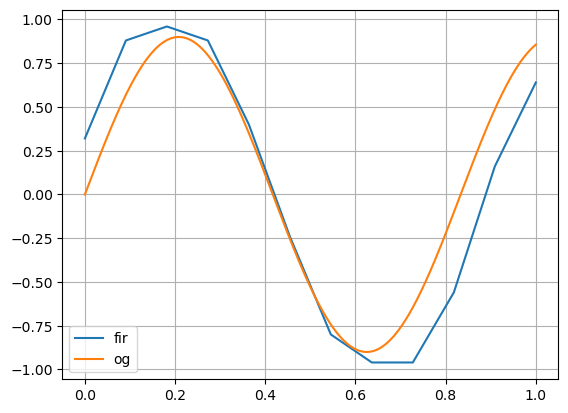

In [115]:
x_fir = np.linspace(0, T, len(fir_out_all))
x = np.linspace(0,T,1000)
plt.plot(x_fir, fir_out_all, label='fir')
plt.plot(x,test_ampSmp(x), label='og')
plt.legend()
plt.grid()

In [14]:
time_vector= np.linspace(0,1,1000)
bins_h = q.qvalue(bins)

fir_out = movingAvg_2(delta =0.08, time=time_vector, transition_inst = t_inst, bins_heights = bins_h, K = 100, T=1)

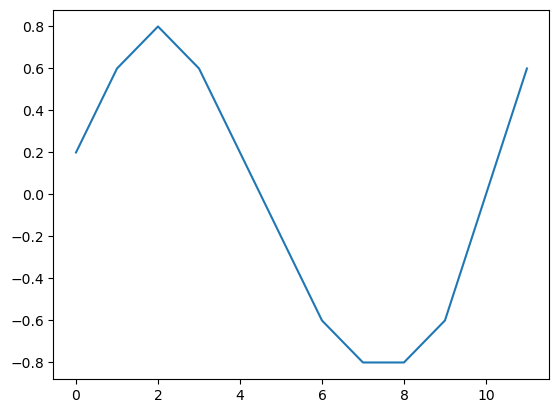

In [15]:
plt.plot(fir_out)

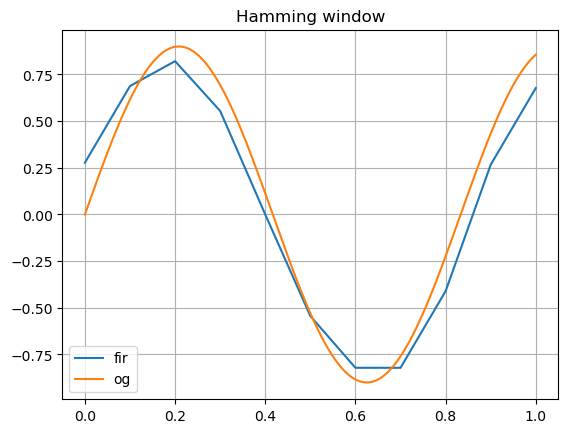

In [64]:
t_inst, bins = amplitude_sampler(test_ampSmp,1, q)
time_vector= np.linspace(0,1,1000)
bins_h = q.qvalue(bins)

fir_out_all  = Hamming(delta = 0.03, time=time_vector, transition_inst = t_inst, bins_heights = bins_h,Td = 0.09, K = 200, W = 3, T=T)

#--------------------------------------------------------------------------
x_fir = np.linspace(0, T, len(fir_out_all))
x = np.linspace(0,T,1000)
plt.plot(x_fir, fir_out_all, label='fir')
plt.plot(x,test_ampSmp(x), label='og')
plt.legend()
plt.title("Hamming window")
plt.grid()
plt.show()

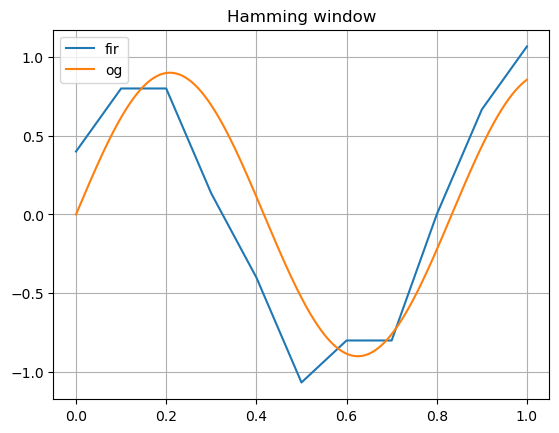

In [87]:
t_inst, bins = amplitude_sampler(test_ampSmp,1, q)
time_vector= np.linspace(0,1,1000)
bins_h = q.qvalue(bins)

fir_out_all  = Bartlett(delta = 0.02, time=time_vector, transition_inst = t_inst, bins_heights = bins_h,Td = 0.09, K = 200, W = 3, T=T)

#--------------------------------------------------------------------------
x_fir = np.linspace(0, T, len(fir_out_all))
x = np.linspace(0,T,1000)
plt.plot(x_fir, fir_out_all, label='fir')
plt.plot(x,test_ampSmp(x), label='og')
plt.legend()
plt.title("Hamming window")
plt.grid()
plt.show()

#### Sawtooth

In [16]:
def sawtooth_test(x):
    f0 = 3 # Hz
    return 0.8* signal.sawtooth(2 * np.pi * f0 * x, 0.7)

In [17]:
t_inst, bins = amplitude_sampler(sawtooth_test,1, q)
time_vector= np.linspace(0,1,1000)
bins_h = q.qvalue(bins)

fir_out_all  = movingAvg(delta = 0.015, time=time_vector, transition_inst = t_inst, bins_heights = bins_h,Td = 0.08, K = 100, W = 5, T=T)

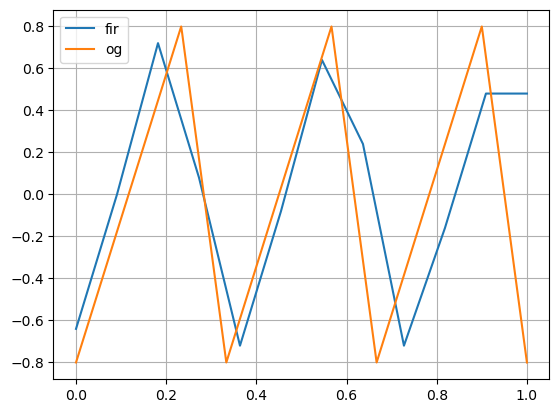

In [18]:
x_fir = np.linspace(0, T, len(fir_out_all))
x = np.linspace(0,T,1000)
plt.plot(x_fir, fir_out_all, label='fir')
plt.plot(x,sawtooth_test(x), label='og')
plt.legend()
plt.grid()

In [20]:
def Hamming(delta, time, transition_inst, bins_heights,Td, K, W, T):
    '''
    :param deltaT: time shift
    :param time: time vector
    :param t_inst: transitions instant
    :param bins_height: height of the bins
    :param k: window size
    :return:
    '''

    filter_out = []
    # delay = 5 taps === 0.05
    for k in range(1,K):
        if Td*k > time.max():
            break
        tn = Td*k
        level_n = find_bin_interval(t_inst, tn, T, bins_heights)
        window_sum = level_n
        for w in range(1,W+1):
            a_w= ( 0.54 - 0.46 * np.cos((2*np.pi*w)/(W-1)))
            tmp = tn-w*delta
            level_tmp = find_bin_interval(t_inst, tmp, T, bins_heights)
            window_sum += level_tmp*a_w

        window_sum = window_sum/W
        filter_out.append(window_sum)

    return filter_out

In [21]:
t_inst, bins = amplitude_sampler(sawtooth_test,1, q)
time_vector= np.linspace(0,1,1000)
bins_h = q.qvalue(bins)

fir_out_all  = Hamming(delta = 0.005, time=time_vector, transition_inst = t_inst, bins_heights = bins_h,Td = 0.05, K = 200, W = 5, T=T)

#--------------------------------------------------------------------------
x_fir = np.linspace(0, T, len(fir_out_all))
x = np.linspace(0,T,1000)
plt.plot(x_fir, fir_out_all, label='fir')
plt.plot(x,sawtooth_test(x), label='og')
plt.legend()
plt.grid()
plt.show()

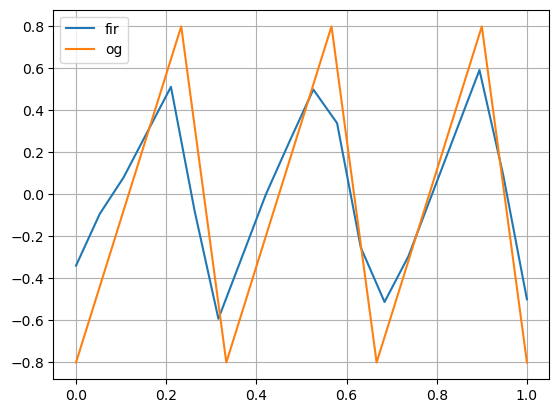

#### Sawtooth

In [23]:
def sawtooth_test(x):
    f0 = 3 # Hz
    return 0.8* signal.sawtooth(2 * np.pi * f0 * x, 0.7)

In [24]:
x= np.linspace(0,1,1000)
q_test, _ = amp_smp(sawtooth_test, T, q, xlim, k, plot= False)
x_smp= x[::2]
q_test_smp = q_test[::2]

In [25]:
f = FIR_class(taps =8, delay = 16)
y= f.movingAvg(x,q_test)
y_smp= f.movingAvg(x_smp, q_test_smp)

(1.7757402168434757+1.0309595753844913j)
(3.66729347049974+1.0893866312471407j)


MSE - Moving average filter =  0.4509262804240057
SNR - Moving average filter =  9.682870131098346
MSE - Moving average - smp filter =  0.6308213395406133
SNR - Moving average - smp filter =  6.193862965957574


C:\Users\Utente\anaconda3\envs\SP_pycharm\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


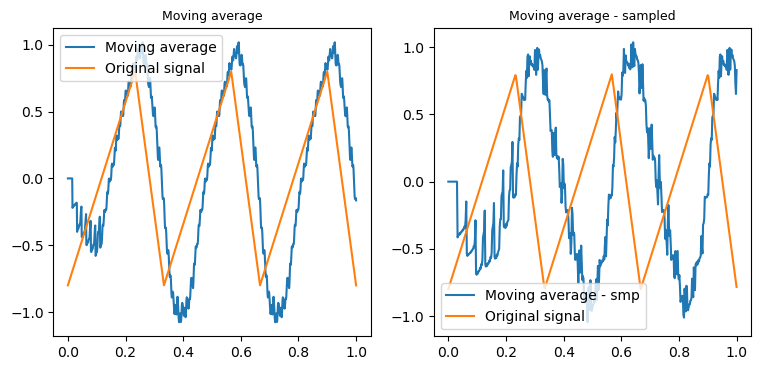

In [26]:
filters_plot('Moving average', x, y,x_smp,y_smp, sawtooth_test(x), sawtooth_test(x_smp))

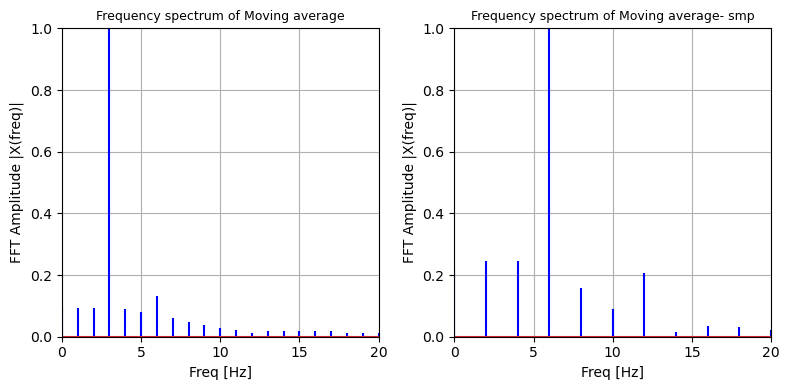

In [27]:
freq_FS, X_FS = utils.fourier_analysis(y, fsmp = 1000)
freq_FS_smp, X_FS_smp = utils.fourier_analysis(y_smp, fsmp = 1000)
#---------------------------------------------------------------------
filters_plot_fourier(freq_FS, X_FS, freq_FS_smp, X_FS_smp, 20, 'Moving average')

(0.3182175584817247+0.2553494787847193j)
(0.39665356896624926+0.37083261127176825j)
MSE - Hamming filter filter =  0.38652552476902524
SNR - Hamming filter filter =  10.89306131132439
MSE - Hamming filter - smp filter =  0.5005474019561781
SNR - Hamming filter - smp filter =  6.952649837556782


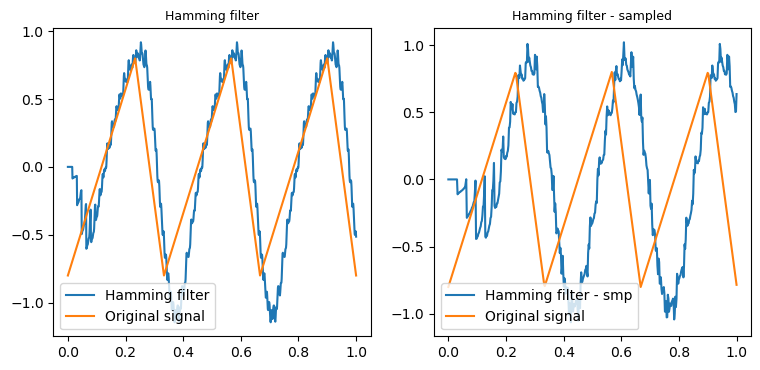

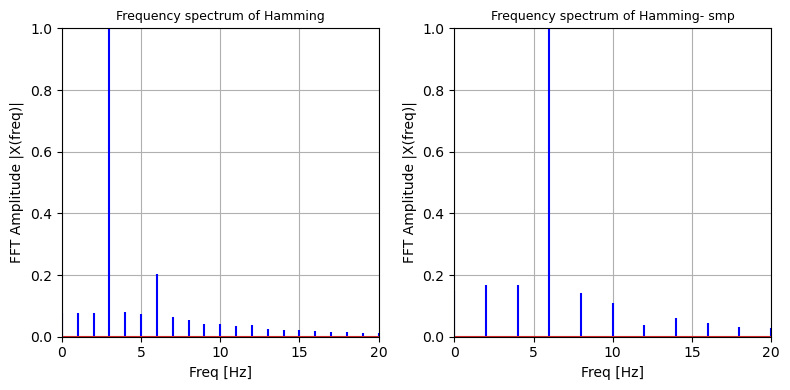

In [28]:
f = FIR_class(taps =8, delay = 16)
y= f.hamming(x,q_test)
y_smp= f.hamming(x_smp, q_test_smp)
filters_plot('Hamming filter', x, y,x_smp,y_smp, sawtooth_test(x), sawtooth_test(x_smp))
#--------------------------------------------------------------
freq_FS, X_FS = utils.fourier_analysis(y, fsmp = 1000)
freq_FS_smp, X_FS_smp = utils.fourier_analysis(y_smp, fsmp = 1000)
filters_plot_fourier(freq_FS, X_FS, freq_FS_smp, X_FS_smp, 20, 'Hamming')

(0.4099428057081238+0.3152727942624527j)
(0.5157876556246999+0.44887638798580076j)
MSE - Bartlett filter =  0.39083569116433436
SNR - Bartlett filter =  11.034486214508812
MSE - Bartlett - smp filter =  0.49641120700017116
SNR - Bartlett - smp filter =  7.074657076718676


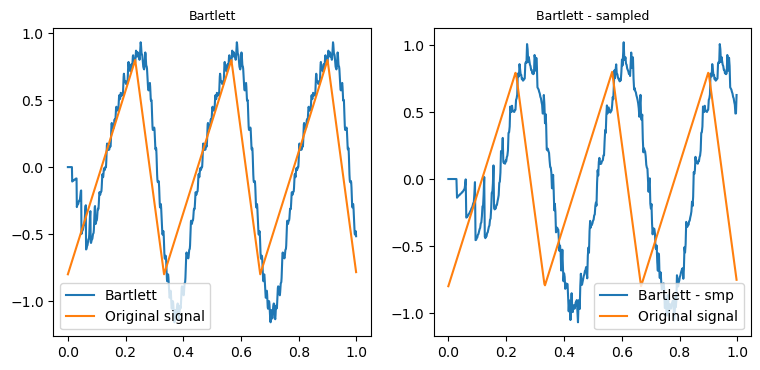

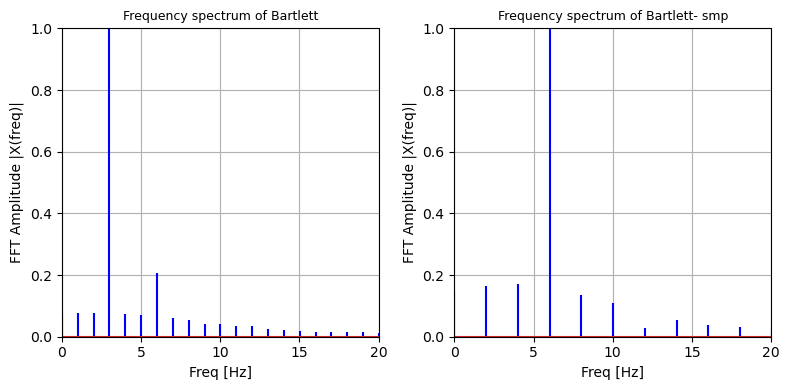

In [29]:
f = FIR_class(taps =8, delay = 16)
y= f.bartlett(x,q_test)
y_smp= f.bartlett(x_smp, q_test_smp)
filters_plot('Bartlett', x[:-1], y,x_smp[:-1],y_smp, sawtooth_test(x)[:-1], sawtooth_test(x_smp)[:-1])
#--------------------------------------------------------------
freq_FS, X_FS = utils.fourier_analysis(y, fsmp = 1000)
freq_FS_smp, X_FS_smp = utils.fourier_analysis(y_smp, fsmp = 1000)
filters_plot_fourier(freq_FS, X_FS, freq_FS_smp, X_FS_smp, 20, 'Bartlett')

### Polynomial

In [30]:
def poly_spline3(x,y):
    spline = CubicSpline(x, y) # Create the cubic spline
    x_range = np.linspace(min(x), max(x), 1000) #spline x range
    y_range = spline(x_range)
    return x_range, y_range

In [31]:
import random
from scipy.interpolate import CubicSpline

x =  np.sort(random.sample(range(1, 20), 10))
y = np.array([random.random() for _ in range(10)])
x_range, y_range = poly_spline3(x,y)

#Normalize
y_range /= y_range.max()
y /= y.max()

# sample data points
x_smp = x_range[::3]
y_smp_og = y_range[::3]
y_smp_og /= y_smp_og.max() # normalize to [-1,1]


In [32]:
q_test = q.quantize(y_range)
q_test_smp = q.quantize(y_smp_og)

1.5517241379310345
2.045454545454546
MSE - Moving average filter =  0.19451428540663832
SNR - Moving average filter =  2.709779494440016
MSE - Moving average - smp filter =  0.32012727968198845
SNR - Moving average - smp filter =  0.5503541486676194


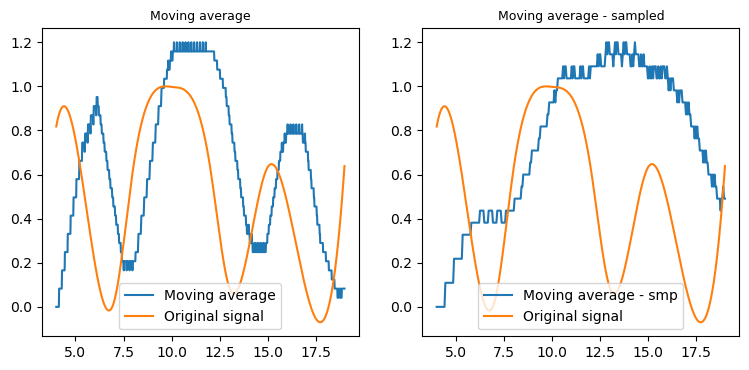

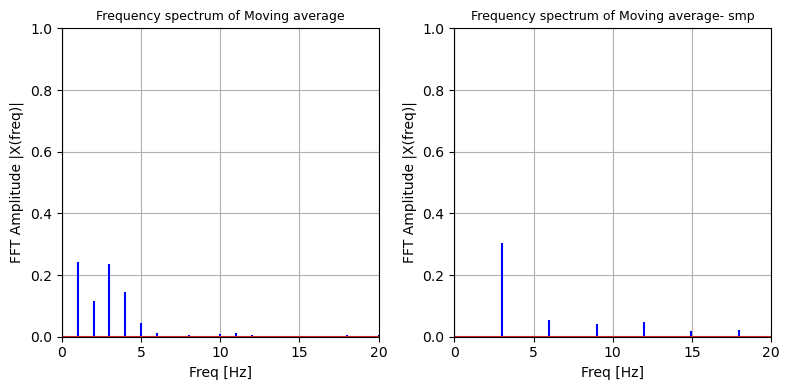

In [33]:
f = FIR_class(taps = 15, delay = 10)
y= f.movingAvg(x_range,q_test)
y_smp= f.movingAvg(x_smp, q_test_smp)
filters_plot('Moving average', x_range, y,x_smp,y_smp, y_range, y_smp_og)
#--------------------------------------------------------------
freq_FS, X_FS = utils.fourier_analysis(y, fsmp = 1000)
freq_FS_smp, X_FS_smp = utils.fourier_analysis(y_smp, fsmp = 1000)
filters_plot_fourier(freq_FS, X_FS, freq_FS_smp, X_FS_smp, 20, 'Moving average')

0.35234237354010606
0.35568431098984304
MSE - Hamming filter filter =  0.15867858179085564
SNR - Hamming filter filter =  3.5941114122371918
MSE - Hamming filter - smp filter =  0.25902187390411496
SNR - Hamming filter - smp filter =  1.4702165806864478


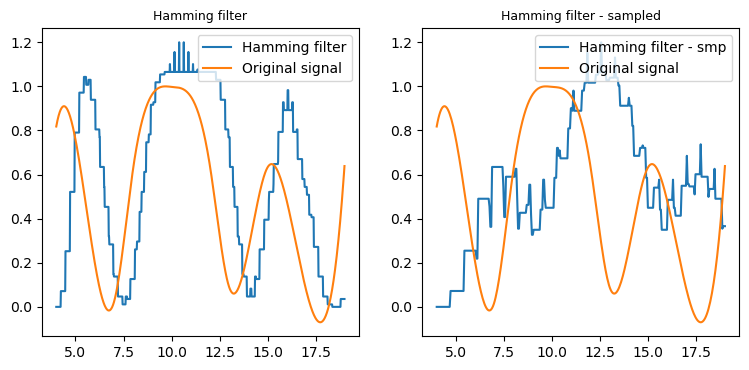

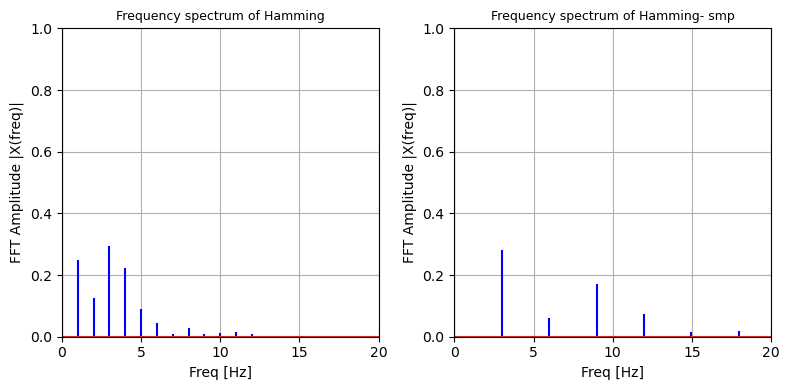

In [34]:
f = FIR_class(taps =8, delay = 16)
y= f.hamming(x_range,q_test)
y_smp= f.hamming(x_smp, q_test_smp)
filters_plot('Hamming filter', x_range, y,x_smp,y_smp, y_range, y_smp_og)
#--------------------------------------------------------------
freq_FS, X_FS = utils.fourier_analysis(y, fsmp = 1000)
freq_FS_smp, X_FS_smp = utils.fourier_analysis(y_smp, fsmp = 1000)
filters_plot_fourier(freq_FS, X_FS, freq_FS_smp, X_FS_smp, 20, 'Hamming')

0.4444444444444444
0.4444444444444444
MSE - Bartlett filter filter =  0.1514965773313368
SNR - Bartlett filter filter =  3.7947297899822092
MSE - Bartlett filter - smp filter =  0.2502666126654504
SNR - Bartlett filter - smp filter =  1.617956556847429


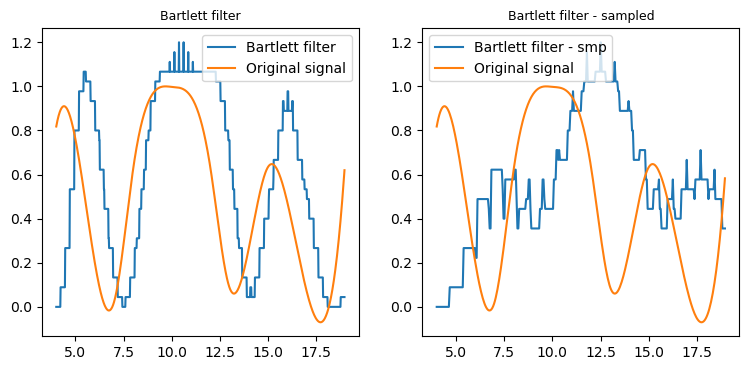

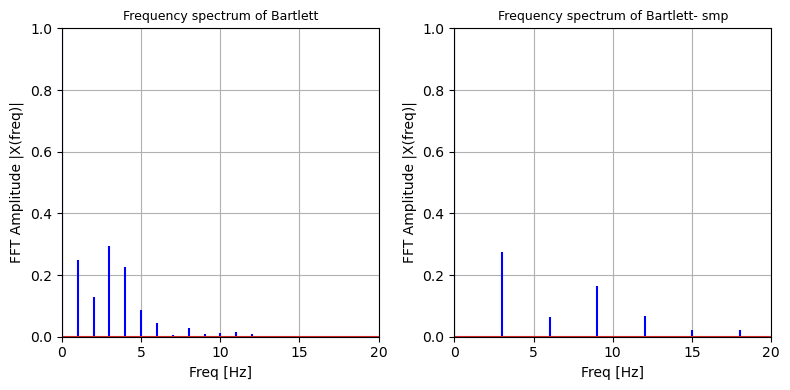

In [35]:
f = FIR_class(taps =8, delay = 16)
y= f.bartlett(x_range,q_test)
y_smp= f.bartlett(x_smp, q_test_smp)
filters_plot('Bartlett filter', x_range[:-1], y,x_smp[:-1],y_smp, y_range[:-1], y_smp_og[:-1])
#--------------------------------------------------------------
freq_FS, X_FS = utils.fourier_analysis(y, fsmp = 1000)
freq_FS_smp, X_FS_smp = utils.fourier_analysis(y_smp, fsmp = 1000)
filters_plot_fourier(freq_FS, X_FS, freq_FS_smp, X_FS_smp, 20, 'Bartlett')